## Лабораторная работа №4. Реализация приложения по распознаванию номеров домов

Перед запуском необходимо скачать файлы notMNIST_large.tar.gz и notMNIST_small.tar.gz, а затем разархивировать их в папку, где находится данный файл.

In [1]:
import os

import numpy as np
import tensorflow as tf
import tensorflow_datasets as tfds
from tensorflow.keras import layers, optimizers

from mypackage import notmnist, tf_utils

`normalize_img` – приводит размер изображения к 32 пикселям в длину и ширину и делает его черно-белым

In [2]:
def normalize_img(image, label):
    image = tf.image.resize(image, [32, 32]) 
    if image.shape[-1] == 3:
        image = tf.image.rgb_to_grayscale(image)
    return tf.cast(image, tf.float32) / 255.0, label

`load_and_prepare_dataset` – загружает и обрабатывает изображения. 10% данных из обучающей выборки используются для валидации.

In [3]:
def load_and_prepare_dataset(dataset_name):
    def prepare_dataset(dataset):
        return dataset.map(normalize_img).cache().batch(64).prefetch(tf.data.AUTOTUNE)
        
    (train_ds, val_ds, test_ds), ds_info = tfds.load(
        dataset_name,
        split=['train[:90%]', 'train[90%:]', 'test'],
        as_supervised=True,
        with_info=True
    )
    
    train_ds = prepare_dataset(train_ds)
    val_ds = prepare_dataset(val_ds)
    test_ds = prepare_dataset(test_ds)
    
    print('Примеры изображений')
    tfds.show_examples(train_ds, ds_info, is_batched=True, rows=1, cols=10, plot_scale=1)
    
    return train_ds, val_ds, test_ds

`get_model` – возвращает модель нейронной сети, которая состоит из 3 сверточных слоев с выбором максимального значения (max-pooling).

In [4]:
def get_model():
    return tf.keras.models.Sequential([
        layers.Conv2D(32, 3, activation='relu', input_shape=(32, 32, 1)),
        layers.MaxPooling2D(pool_size=(2, 2)),
        layers.Conv2D(64, 3, activation='relu'),
        layers.MaxPooling2D(pool_size=(2, 2)),
        layers.Conv2D(128, 5, activation='relu'),
        layers.Flatten(),
        layers.Dense(10, activation='softmax')
    ])

`train_model` – обучает модель

In [5]:
def train_model(model, train_ds, val_ds):
    model.compile(
        optimizer=optimizers.SGD(learning_rate=0.1),
        loss='sparse_categorical_crossentropy',
        metrics=['accuracy']
    )
    
    return model.fit(
        train_ds,
        epochs=10, 
        validation_data=val_ds, 
        verbose=0
    )

### Задание 1

Реализация нейронной сети, обученной на синтетических данных (набор MNIST).

Примеры изображений


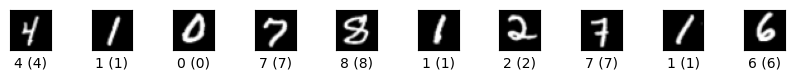

In [6]:
mnist_train_ds, mnist_val_ds, mnist_test_ds = load_and_prepare_dataset('mnist')

In [7]:
model = get_model()
history = train_model(model, mnist_train_ds, mnist_val_ds)

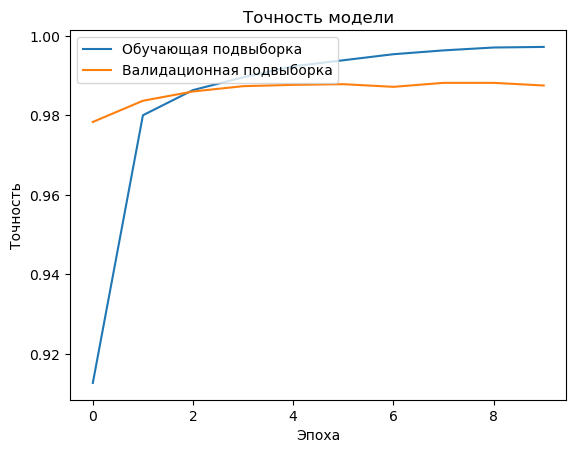

обучающая подвыборка	 – потери: 0.0097 – точность: 0.9972

валидационная подвыборка – потери: 0.0448 – точность: 0.9875

контрольная подвыборка	 – потери: 0.0444 – точность: 0.9864


In [8]:
tf_utils.plot_history(history)
control_loss, control_accuracy = model.evaluate(mnist_test_ds, verbose=0)
tf_utils.print_result(history, control_loss, control_accuracy)

### Задание 2

Обучение нейронной сети на реальных данных (набор SVHN).

Примеры изображений


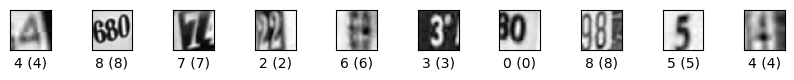

In [9]:
svhn_train_ds, svhn_val_ds, svhn_test_ds = load_and_prepare_dataset('svhn_cropped')

In [10]:
model = get_model()
history = train_model(model, svhn_train_ds, svhn_val_ds)

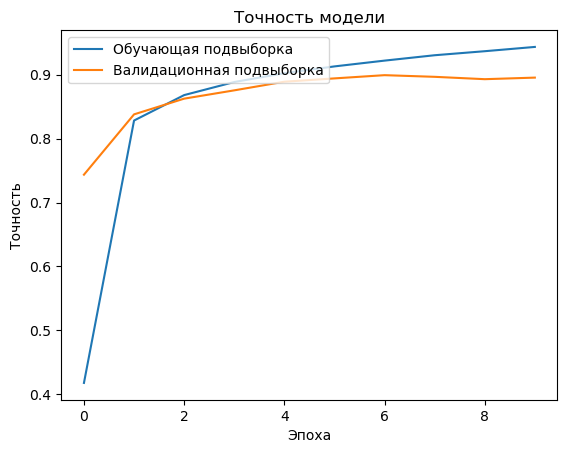

обучающая подвыборка	 – потери: 0.2038 – точность: 0.9433

валидационная подвыборка – потери: 0.4244 – точность: 0.8953

контрольная подвыборка	 – потери: 0.4990 – точность: 0.8856


In [11]:
tf_utils.plot_history(history)
control_loss, control_accuracy = model.evaluate(svhn_test_ds, verbose=0)
tf_utils.print_result(history, control_loss, control_accuracy)

#### Анализ результатов:

Точность модели, обученной на синтетических данных (MNIST), составляет **98.64%**.

Точность модели, обученной на реальных данных (SVHN), составляет **88.56%**.

Снижение точности обусловлено тем, что набор SVHN содержит более сложные изображения, чем MNIST. Цифры на изображениях SVHN могут быть искажены, находиться в различных условиях освещения и иметь разные цвета.


### Задание 3

Формирование множежества снимков номеров домов. Фотографии доступны в папке photo.

In [12]:
PHOTO_FOLDER_PATH = r'photo\digits'

### Задание 4

Сохранение модели для android приложения.

In [13]:
SVHN_MODEL_ANDROID_APP_PATH = r'ml-android-app\app\src\main\assets\svhn_model.tflite'

In [ ]:
converter = tf.lite.TFLiteConverter.from_keras_model(model)
tflite_model = converter.convert()

with open(SVHN_MODEL_ANDROID_APP_PATH, 'wb') as f:
    f.write(tflite_model)

Определение точности модели на собственных данных.

In [14]:
dataset = {}
for folder_path in os.listdir(PHOTO_FOLDER_PATH):
    dataset[folder_path] = notmnist.get_images(
        os.path.join(PHOTO_FOLDER_PATH, folder_path),
        is_verbose=False
    )

In [15]:
interpreter = tf.lite.Interpreter(model_path=SVHN_MODEL_ANDROID_APP_PATH)
interpreter.allocate_tensors()

input_details = interpreter.get_input_details()
output_details = interpreter.get_output_details()

In [16]:
correct_predictions = 0
total_predictions = 0

for class_name, images in dataset.items():
    for image in images:
        input_data = tf.reshape(normalize_img(image, class_name)[0], (1, 32, 32, 1))
        interpreter.set_tensor(input_details[0]['index'], input_data)
        interpreter.invoke()
        predicted_class = np.argmax(interpreter.get_tensor(output_details[0]['index']))
    
        total_predictions += 1
        if predicted_class == int(class_name):
            correct_predictions += 1

accuracy = correct_predictions / total_predictions
print(f'Точность: {accuracy * 100:.2f}%')

Точность: 90.62%
